# CS 269Q: Final Project - QAOA on MIS
***
## Part 1: Using Classical Optimizer

__Note:__ Part 2: Using Grid Search is documented on another notebook.

__GOAL:__ Generate random MIS instances for simulation on the QVM and benchmark against various noise models.

In [1]:
from pyquil import Program
from pyquil.api import WavefunctionSimulator
from pyquil.gates import H, I, RX, CNOT, RESET, MEASURE
from pyquil.paulis import sZ, sX, sI, exponentiate_commuting_pauli_sum
from scipy.optimize import minimize

import operator
import numpy as np
from typing import List, Tuple
import matplotlib.pyplot as plt

From arXiv:1808.10816v1 [quant-ph], the variational wavefunctionn is prepared using the following hamiltonians:

$$H_c = \sum_{v \in V} -\Delta n_v + \sum_{(v,w) \in E} U n_v n_w$$

$$H_d = \sum_{v \in V} \Omega \sigma_v^x + \sum_{(v,w) \in E} U n_v n_w$$

where $n_v = |1>_v<1| = \frac{I - \sigma_z}{2}$

__Generating Graphs:__ For the purposes of this project, I will be generating the random graphs in Wolfram Mathematica using the command `g = RandomGraph[{nodes, edges}]` and then retrieving the edge representation using `EdgeList[g]` where g is the graph I generated. I chose Mathematica, as it can be used to calculate the Maximum Independent Set of the graph using the command `Sort[FindIndependentVertexSet[g, Length /@ FindIndependentVertexSet[g], All]]` and thus verify the solution found via QAOA.

## Section 1: Running on the QVM

In [2]:
def elist_from_math(string: str) -> str:
    '''
    Formats the edge list provided by Mathematica.
    '''
    string = string.replace(',','), (')
    string = string.replace(' <->',',')
    return eval('(' + string + ')')

In [3]:
def get_hamil(num_nodes: int, edge_list: List[Tuple[int, int]], delta: float, 
              U: float, omega: float) -> 'PauliSum, PauliSum':
    '''
    For a given graph, and values of hyperparameters, returns the cost and driver Hamiltonians.
    '''
    # Mathematica labels nodes starting at 1 but we label qubits starting at 0
    nodes = list(range(0,num_nodes))
    edges = [(i-1,j-1) for i,j in edge_list]
    
    h_cost = -0.5* delta * sum((sI(i) - sZ(i)) for i in nodes) + 0.25 * U * sum((sI(i) - sZ(i))*(sI(j) - sZ(j)) for i, j in edges)
    h_driver = omega*sum(sX(i) for i in nodes) + 0.25*U * sum((sI(i) - sZ(i))*(sI(j) - sZ(j)) for i, j in edges)
    return h_cost, h_driver

### Noisless Implementation

In [4]:
def mis_ansatz(betas: List[float], gammas: List[float]) -> Program:
    '''
    Returns the program to create the MIS ansatz.
    '''
    pq = Program(RESET())
    pq += [exponentiate_commuting_pauli_sum(h_cost)(g) + exponentiate_commuting_pauli_sum(h_driver)(b) 
                for g, b in zip(gammas, betas)]
    return pq

In [5]:
def mis_cost(params: List[float]) -> float:
    '''
    Returns the value of the cost function given params.
    '''
    half = int(len(params)/2)
    betas, gammas = params[:half], params[half:]
    pq = mis_ansatz(betas, gammas)
    return WavefunctionSimulator().expectation(prep_prog = pq, pauli_terms = h_cost)

__Before__ defining the next function, decide how much resource you want to allocate to the classical optimizer and edit the function accordingly.

In [6]:
def run_qaoa_mis(p: int, params: List[float], correct_state: str) -> 'dict key-value pair, float':
    '''
    Returns the mpost probable state and its probability, and the probability of the correct state.
    '''
    # Scaling max iteration for a given p to make a the comparison more standard
    iters = 50*p
    print("p value:", p, "and number of iters:", iters)
    result = minimize(mis_cost, x0 = params, method='Nelder-Mead', options={'disp': True, 'maxiter': iters})
    
    # unlimited iterations
    # result = minimize(mis_cost, x0 = params, method='Nelder-Mead', options={'disp': True})
    
    print('The optimal parameters are:', result['x'])
    
    half = int(len(result['x'])/2)
    pq = mis_ansatz(result['x'][:half],result['x'][half:])
    
    wf_sim = WavefunctionSimulator()
    wavefunction = wf_sim.wavefunction(pq)
    prob_dict = wavefunction.get_outcome_probs() 
    sorted_dict = sorted(prob_dict.items(), key = operator.itemgetter(1))
    return sorted_dict[len(prob_dict)-1], prob_dict.get(correct_state)

In [7]:
def run_p_range(max_p: int, correct_state: str) -> 'List[int], List[float], List[str]':
    '''
    Runs QAOA on MIS for multiple p values from 1 to max_p.
    '''
    p_vals = []
    prob_vals = []
    colors = []
    for p in range(1, max_p + 1):
        p_vals.append(p)
        params = [0.5] * 2 * p
        result, prob_correct = run_qaoa_mis(p, params, correct)
        if (result[0] == correct):
            print("GOOD p value:", p, "with State:", result[0])        
            prob_vals.append(result[1])
            colors.append('g')
        else:
            print("BAD p value:", p, "with State:", result[0])
            prob_vals.append(prob_correct)
            colors.append('r')
    return p_vals, prob_vals, colors

#### Running QAOA on MIS without Noise

1. First we must get the edge list from Mathematica, and set the hyperparameters $\Delta, U$ and $\omega$. Also get the cost and the driver hamiltonians. 

In [8]:
# elist = [(1, 4), (1, 7), (1, 8), (1, 9), (1, 10), (2, 5), (2, 6), (2, 8), (3, 4), (3, 5),
#         (3, 7), (4, 7), (4, 10), (5, 6), (5, 9), (6, 7), (6, 9), (6, 10), (7, 9), (9, 10)]
# string = '1 <-> 2, 1 <-> 3, 1 <-> 4, 1 <-> 5, 2 <-> 7, 3 <-> 4, 3 <-> 7, 4 <-> 6, 4 <-> 7, 7 <-> 8' # graph2 
string = '1 <-> 2, 1 <-> 3, 1 <-> 4, 1 <-> 5, 2 <-> 3, 2 <-> 4, 2 <-> 5, 3 <-> 4, 4 <-> 5' # graph3

elist = elist_from_math(string)

# SET THESE PARAMS
num_nodes = 5 # update
delta = 1
U = 1.5
omega = 0.5

h_cost, h_driver = get_hamil(num_nodes, elist, delta, U, omega)

2. Ensure that you set your parameters correctly by running QAOA for p = 2. Currently p = 1 does not result in the correct answer.

__Note:__ The qubits are labelled from the right.

In [9]:
%%time

# check that we get the expected result
# correct = '1011010000'
# correct = '10110110'
correct = '10100'

result, prob_correct = run_qaoa_mis(2, [0.5, 0.5, 0.5, 0.5], correct)
print(result)
print(prob_correct)

p value: 2 and number of iters: 100
The optimal parameters are: [ 1.07431624  0.43319211  0.820297   -0.26461078]
('10100', 0.10241357111186623)
0.10241357111186623
CPU times: user 2.22 s, sys: 57.2 ms, total: 2.27 s
Wall time: 3.66 s


3. Set the maximum p value you want to run for, and run the algorithm!

In [10]:
%%time

# SET THIS VALUE
p_max = 10

p_vals, prob_vals, colors = run_p_range(p_max, correct)

p value: 1 and number of iters: 50
The optimal parameters are: [0.88971994 0.34889003]
BAD p value: 1 with State: 00000
p value: 2 and number of iters: 100
The optimal parameters are: [ 1.07431624  0.43319211  0.820297   -0.26461078]
GOOD p value: 2 with State: 10100
p value: 3 and number of iters: 150
The optimal parameters are: [ 1.15876258  0.56519082  0.30656376  0.34147958 -0.25011985  0.89223014]
GOOD p value: 3 with State: 10100
p value: 4 and number of iters: 200
The optimal parameters are: [ 1.12986714  0.45820024  0.38385772  0.19780439  0.45239111 -0.6300602
  0.35262858  1.09618274]
GOOD p value: 4 with State: 10100
p value: 5 and number of iters: 250
The optimal parameters are: [ 1.0219468   0.51459692  0.36585327  0.25401614  0.15629477  2.20410124
 -0.46540335 -0.01020403  0.59382447  1.77892594]
GOOD p value: 5 with State: 10100
p value: 6 and number of iters: 300
The optimal parameters are: [ 1.10821962  0.46740385  0.41068923  0.37442257  0.236326    0.20109152
  0.05

4. To see how QAOA performed on your graph, plot the results. Red color means that the most probable state was not the correct state, while green means that it was.

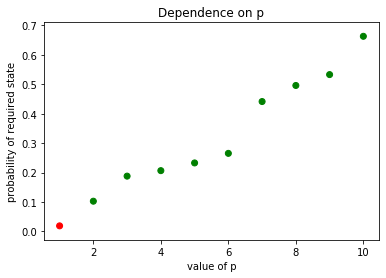

In [16]:
plt.scatter(p_vals, prob_vals, color = colors) 
plt.title("Dependence on p")
plt.xlabel("value of p")
plt.ylabel("probability of required state")
# plt.savefig("pgraph3.png")
plt.show()

In [29]:
prob_vals

[0.018551935726479268,
 0.10241357111186623,
 0.18766430160452127,
 0.20634872203745952,
 0.23254463830689542,
 0.265105699991763,
 0.44133566005393843,
 0.4959777926613009,
 0.5329919262665037,
 0.6631958811106692]

#### Plotting all values

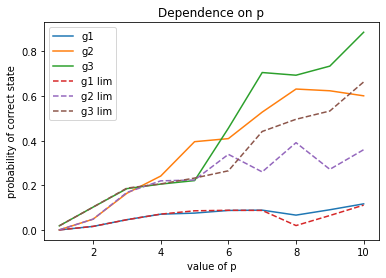

In [36]:
paxis = list(range(1,11))
plt.plot(paxis, [0.0002584088825309589, 0.016013513616306287, 0.04617072571470806, 0.07077191741821537, 0.07560195740556094,
 0.08751310563042256, 0.08883531569983363, 0.06653509811964456, 0.09057367498538071, 0.11702668124351008], label = 'g1') 
plt.plot(paxis, [0.0005317994423599302, 0.04844621167737637, 0.16448419711373685, 0.24162292345998884, 0.3955198436659364,
  0.409267066296394, 0.5279943164193701, 0.6313983067454861, 0.623606445096216, 0.6009971137120277], label = 'g2')
plt.plot(paxis, [0.018551935708694726, 0.10241589381176734, 0.1852167182088925, 0.20558281325232938, 0.2212128411269047,
 0.4559834830957632, 0.7053359374171075, 0.6933577935722443, 0.7340931703510583, 0.8858375563026535], label = 'g3')
plt.plot(paxis, [0.00025840888373638513, 0.016007294155534146, 0.046026503812618504, 0.07110633993353646, 0.08592458108855694,
 0.08822873035040116, 0.08756065585648515, 0.019802383927298148, 0.06475600039004104, 0.11134665527605557], '--', label = 'g1 lim')
plt.plot(paxis, [0.0005317994423599302, 0.04846068694867068, 0.16833435898860002, 0.22010295717138745, 0.22399681825545284,
 0.338817328756781, 0.2601803984751079, 0.39111098722327375, 0.2717148731462373, 0.3596595186476516], '--', label = 'g2 lim')
plt.plot(paxis, [0.018551935726479268, 0.10241357111186623, 0.18766430160452127, 0.20634872203745952, 0.23254463830689542,
 0.265105699991763, 0.44133566005393843, 0.4959777926613009, 0.5329919262665037, 0.6631958811106692], '--', label = 'g3 lim')
plt.title("Dependence on p")
plt.xlabel("value of p")
plt.ylabel("probability of correct state")
plt.legend()
# plt.savefig("p_depth_lim.png")
plt.show()

### Implementation with Noise

To add noise to our program using the PyQuil noise module, we first need to convert our program to the form where it uses the module's specific gate set. To do this, we will be using quilc.

In [10]:
from pyquil.api import get_qc

# SET NUMBER OF QUBITS
num_nodes = 5

qc = get_qc(str(num_nodes)+"q-qvm")

In [11]:
def make_native(program):
    ep = qc.compile(program)
    return ep

Now, we define a new version of the ansatz that adds noise to the program.

In [12]:
from pyquil import noise

def mis_noisy_ansatz(params: List[float], t1, t2) -> Program:
    '''
    Returns the program to create the noisy MIS ansatz.
    '''
    half = int(len(params)/2)
    betas, gammas = params[:half], params[half:]
    
    pq = Program(RESET())
    pq += [exponentiate_commuting_pauli_sum(h_cost)(g) + exponentiate_commuting_pauli_sum(h_driver)(b) 
                for g, b in zip(gammas, betas)]
    pq = make_native(pq)
    pq = noise.add_decoherence_noise(Program(pq.program), T1 = t1, T2 = t2)
    return pq

We have the optimized parameters from the noiseless analysis. Let's see how these solutions depend on the values of T1 and T2.

In [43]:
%%time

wf_sim = WavefunctionSimulator()

# SET PARAMS calculated from noiseless analysis
params = [ 1.07431624,  0.43319211,   0.820297,   -0.26461078]
# params = [ 1.12986714,  0.45820024,  0.38385772,  0.19780439,  0.45239111, -0.6300602,  0.35262858,  1.09618274]
# params = [ 1.17898073,  0.69353505,  0.59287688,  0.71985545,  0.63707136,  0.55636486,  0.38097755,  0.47368145,
#          -0.11926148,  0.39201166,  0.62561161,  0.37987722,  0.48987259,  0.394838 ]

correct = '10100'

times = np.logspace(-7,-3,20)
probs = []
colors = []

for t1 in times:
    prog = mis_noisy_ansatz(params, t1, 2*t1)
    wavefunction = wf_sim.wavefunction(prog)
    prob_dict = wavefunction.get_outcome_probs() 
    sorted_dict = sorted(prob_dict.items(), key = operator.itemgetter(1))
    if sorted_dict[len(prob_dict)-1][0] == correct:
        probs.append(sorted_dict[len(prob_dict)-1][1])
        colors.append('g')
    else:
        probs.append(prob_dict.get(correct))
        colors.append('r')

CPU times: user 7.03 s, sys: 9.95 ms, total: 7.04 s
Wall time: 18.9 s


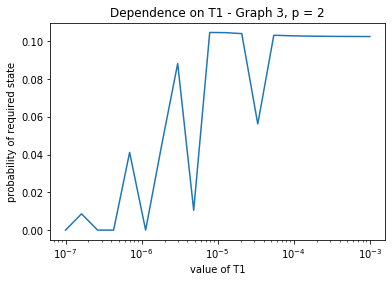

In [44]:
plt.plot(times, probs) 
plt.title("Dependence on T1 - Graph 3, p = 2")
plt.xlabel("value of T1")
plt.ylabel("probability of required state")
#plt.savefig("t1_3_4.png")
plt.xscale('log')
plt.show()

In [45]:
probs

[5.706273277226982e-06,
 0.00862779769790872,
 0.0,
 0.0,
 0.041144249933973656,
 0.0,
 0.04493611436432071,
 0.08817833003484794,
 0.010500312848269546,
 0.1046199098174919,
 0.1045028884990306,
 0.10399808633186648,
 0.05617575287306052,
 0.1031322750738719,
 0.1028736364523944,
 0.10270356756104083,
 0.1025947036816087,
 0.10252608652974315,
 0.10248323011671143,
 0.10245660958539544]

#### Plotting all values

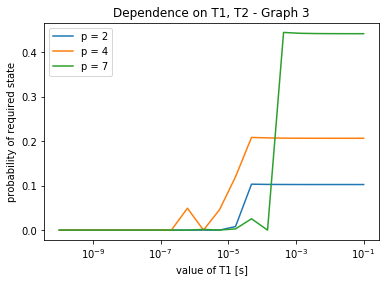

In [34]:
plt.plot(times, [0.0, 0.0, 0.0, 0.0, 7.29172007716542e-23, 0.0, 2.392043967743857e-07, 0.0, 0.0, 0.0, 0.0, 0.007961072635407013,
 0.10321420660767898, 0.10270356756104083, 0.10251340140137408, 0.1024473836374872, 0.10242496201401485, 0.10241740153257967,
 0.1024148582738098, 0.1024140034379788], label = 'p = 2') 
plt.plot(times, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.9225408540239596e-07, 0.00022999052048774992, 0.049184568944435604, 0.0,
 0.045728583953194187, 0.11968922423249545, 0.2082610976773786, 0.20719138097810103, 0.20665446426547446, 0.20645399841430911,
 0.20638438080516858, 0.2063607349715337, 0.20635276155303414, 0.2063500793729442], label = 'p = 4')
plt.plot(times, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.321981744538661e-05, 3.9047760675492715e-05, 0.0015686204503593832, 0.00019135951718935766,
 0.0026936116210448326, 0.025506543648392953, 8.340309106853962e-08, 0.4441653621778469, 0.4422912982138006, 0.4416572922163946,
 0.44144378670945944, 0.4413719973329165, 0.44134787115330254], label = 'p = 7')
plt.title("Dependence on T1, T2 - Graph 3")
plt.xlabel("value of T1 [s]")
plt.ylabel("probability of required state")
plt.xscale('log')
plt.legend()
#plt.savefig("t1.png")
plt.show()

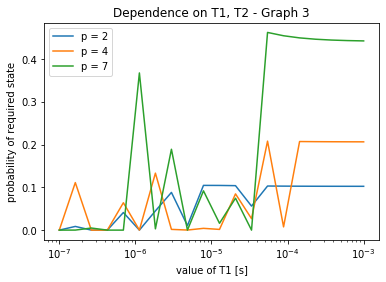

In [47]:
plt.plot(times, [5.706273277226982e-06, 0.00862779769790872, 0.0, 0.0, 0.041144249933973656, 0.0, 0.04493611436432071,
                 0.08817833003484794, 0.010500312848269546, 0.1046199098174919, 0.1045028884990306, 0.10399808633186648,
                 0.05617575287306052, 0.1031322750738719, 0.1028736364523944, 0.10270356756104083, 0.1025947036816087,
                 0.10252608652974315, 0.10248323011671143, 0.10245660958539544] , label = 'p = 2') 
plt.plot(times, [0.0, 0.11114316828751238, 0.0, 0.0, 0.06403845463992265, 6.424012944220585e-05, 0.13327034851442127,
                 0.0017216771373550065, 0.00018241299609454857, 0.004135473684677462, 0.0016547071868690793,
                 0.08478059398935327, 0.02684420569092727, 0.20813333086619476, 0.007569149679292924, 0.20719138097810103,
                  0.20689166546411025, 0.20669219100650507, 0.20656369661543866, 0.20648242183039622], label = 'p = 4')
plt.plot(times, [0.0, 7.331712366297175e-05, 0.004871714734507481, 0.0, 0.0, 0.36764439640682844, 0.0029539439074752977,
                 0.18912509625555585, 0.0, 0.09187034676437467, 0.01592443537139975, 0.07467016094881482, 0.0,
                 0.4623521516237755, 0.45460209641845595, 0.44962807897624435, 0.4464888031343465, 0.44452673235159906,
                 0.4433075129088483, 0.44255253780302745], label = 'p = 7')
plt.title("Dependence on T1, T2 - Graph 3")
plt.xlabel("value of T1 [s]")
plt.ylabel("probability of required state")
plt.xscale('log')
plt.legend()
#plt.savefig("t1_zoom.png")
plt.show()

_______________

# Future Work

__I can do 5 types of analyses:__
1. Let Nealder-Mead run forever - tried
2. Stop at 100 or certain number of iters that scales with p - tried p*50
3. Grid search for params - need to implement properly
4. Grid search with width decreasing - takes too long - how to improve?
5. Adding noise - takes long - how to improve?

## Section 2: Running on the QPU

In [2]:
from pyquil.gates import MEASURE, X
import itertools

In [3]:
from pyquil import get_qc
from pyquil.api._devices import list_devices, list_lattices

In [4]:
def get_hamil(nodes: List[int], edges: List[Tuple[int, int]], delta: float, 
              U: float, omega: float) -> 'PauliSum, PauliSum':
    '''
    For a given graph, and values of hyperparameters, returns the cost and driver Hamiltonians.
    '''
    h_cost = -0.5* delta * sum((sI(i) - sZ(i)) for i in nodes) + 0.25 * U * sum((sI(i) - sZ(i))*(sI(j) - sZ(j)) for i, j in edges)
    h_driver = omega*sum(sX(i) for i in nodes) + 0.25*U * sum((sI(i) - sZ(i))*(sI(j) - sZ(j)) for i, j in edges)
    return h_cost, h_driver

In [5]:
def mis_qpu_ansatz(betas: List[float], gammas: List[float], qubits) -> Program:
    '''
    Returns the program to create the MIS ansatz.
    '''    
    pq = Program(RESET())
    pq += [exponentiate_commuting_pauli_sum(h_cost)(g) + exponentiate_commuting_pauli_sum(h_driver)(b) 
                for g, b in zip(gammas, betas)]
    ro = pq.declare('ro', 'BIT', len(qubits))
    pq.inst([MEASURE(qubit, ro[idx]) for idx, qubit in enumerate(qubits)])
    return pq

In [6]:
from pyquil.gates import I, X
from pyquil.api import WavefunctionSimulator

def bit_energy(bitstring, h_cost):
    size = len(bitstring)
    pq = Program()
    for i in range(size):
        if bitstring[i] == 0:
            pq += Program(I(i))
        elif bitstring[i] == 1:
            pq += Program(X(i))
    return np.real(WavefunctionSimulator().expectation(prep_prog = pq, pauli_terms = h_cost))

In [8]:
device_names = list_devices()  # Available devices are subject to change.
lattice_names = list(list_lattices().keys())  # Available lattices are subject to change.
print(f"Available devices: {device_names}.\n")
print(f"Available lattices: {lattice_names}.")

Available devices: ['Aspen-4'].

Available lattices: ['Aspen-4-2Q-A', 'Aspen-4-3Q-A', 'Aspen-4-4Q-A', 'Aspen-4-5Q-A', 'Aspen-4-6Q-A', 'Aspen-4-7Q-A', 'Aspen-4-8Q-A', 'Aspen-4-9Q-A', 'Aspen-4-10Q-A', 'Aspen-4-15Q-A', 'Aspen-4-11Q-A', 'Aspen-4-12Q-A', 'Aspen-4-13Q-A', 'Aspen-4-14Q-B', 'Aspen-4-16Q-A'].


In [9]:
qpu = get_qc('Aspen-4-5Q-A')

In [10]:
nodes = [0,1,2,7,15]
elist = [(0,7),(0,1)]

# SET THESE PARAMS
delta = 1
U = 1.5
omega = 0.5

h_cost, h_driver = get_hamil(nodes, elist, delta, U, omega)

In [11]:
mis_program = mis_qpu_ansatz([0.5], [0.5], nodes)

# mis_program = Program(RESET(), X(1))
# ro = mis_program.declare('ro', 'BIT', 1)
# mis_program.inst(MEASURE(1, 0))

mis_program.wrap_in_numshots_loop(10_000)
binary = qpu.compile(mis_program)

In [13]:
big_results_array = qpu.run(binary)

In [20]:
np.array(results)[0]

array([1])

In [41]:
result = np.array(results)
score = 0
for x in result:
    if (np.count_nonzero(x) > 0):
            score += 1 
print(score)   

9751


In [42]:
results

array([[1, 1, 1, 0, 1],
       [1, 0, 1, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0],
       [1, 1, 0, 0, 0]])

In [34]:
def mis_cost(params: List[float]) -> float:
    '''
    Returns the value of the cost function given params.
    '''
    half = int(len(params)/2)
    betas, gammas = params[:half], params[half:]
    pq = mis_qpu_ansatz(betas, gammas, [0,1,2,7,15])
    pq.wrap_in_numshots_loop(1)
    binary = qpu.compile(pq)
    output = qpu.run(binary)
    return sum(bit_energy_prime(x) for x in output)

In [31]:
def bit_energy_prime(x):
    bitstring = ''.join(str(e) for e in x)
    if bitstring == '01111':
        return -1
    else:
        return 1

In [21]:
def run_p_range_qpu(max_p: int, correct_state: str) -> 'List[int], List[float], List[str]':
    '''
    Runs QAOA on MIS for multiple p values from 1 to max_p.
    '''
    p_vals = []
    prob_vals = []
    colors = []
    for p in range(1, max_p + 1):
        p_vals.append(p)
        params = [0.5] * 2 * p
        half = int(len(params)/2)
        betas, gammas = params[:half], params[half:]
        mis_program = mis_qpu_ansatz(betas, gammas, nodes)
        mis_program.wrap_in_numshots_loop(10_000)
        binary = qpu.compile(mis_program)
        results = qpu.run(binary)
        if (result[0] == correct):
            print("GOOD p value:", p, "with State:", result[0])        
            prob_vals.append(result[1])
            colors.append('g')
        else:
            print("BAD p value:", p, "with State:", result[0])
            prob_vals.append(prob_correct)
            colors.append('r')
    return p_vals, prob_vals, colors

In [37]:
p_range = []
big_results_array = []
for p in range(1, 5):
    print(p)
    p_range.append(p)
    params = [0.5] * 2 * p
    params = (minimize(mis_cost, x0 = params, method='Nelder-Mead', options={'disp': True, 'maxiter': 10}))['x']
    half = int(len(params)/2)
    betas, gammas = params[:half], params[half:]
    mis_program = mis_qpu_ansatz(betas, gammas, nodes)
    mis_program.wrap_in_numshots_loop(10_000)
    binary = qpu.compile(mis_program)
    results = qpu.run(binary)
    big_results_array.append(results)    

1
Optimization terminated successfully.
         Current function value: 1.000000
         Iterations: 9
         Function evaluations: 35
2
Optimization terminated successfully.
         Current function value: 1.000000
         Iterations: 9
         Function evaluations: 53
3
4


In [127]:
[0.5] * 2 * 5

[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

In [111]:
big_results_array[0]

array([[0, 0, 1, 0, 0],
       [1, 1, 0, 1, 0],
       [1, 0, 1, 1, 1],
       ...,
       [1, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 1, 1, 0]])

In [46]:
list1 = [1, 2, 3]
str1 = ''.join(str(e) for e in list1)

In [49]:
count = {}
type(count)

dict

In [38]:
for p, p_results in enumerate(big_results_array):
    p_results_bit = []
    for result in p_results:
        p_results_bit.append(''.join(str(e) for e in result))
    _, counts = np.unique(p_results_bit, return_counts = True)
    print(max(counts)/10000)

0.1121
0.0647
0.0489
0.0457


In [82]:
count = {}

for a in big_results_array[9]:
    bitstring = ''.join(str(e) for e in a)
    if bitstring in count:
        count[bitstring] += 1
    else:
        count[bitstring] = 1
    sorted_count = sorted(count.items(), key = operator.itemgetter(1))

sorted_count[len(sorted_count)-1][1]

953